In [268]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools
from joblib import Parallel, delayed
import os
import multiprocessing

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import sklearn.model_selection as skm

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm

from keras.models import Sequential
from keras.layers import Dense

from scipy.interpolate import Akima1DInterpolator
from scipy.interpolate import barycentric_interpolate

In [269]:
data1 = pd.read_csv("BETN073-1990_2012.csv")
data2 = pd.read_csv("BETN073-2013_2022.csv")
ozone_data = pd.concat([data1,data2])
ozone_data = ozone_data.reset_index()

In [270]:
ozone_data['Validity'].unique()

array([ 1, -1,  0], dtype=int64)

In [271]:
# Display examples for each unique value in 'Validity' column
for value in ozone_data['Validity'].unique():
    examples = ozone_data[ozone_data['Validity'] == value].head()
    print(f"Examples for Validity {value}:\n{examples}\n")

Examples for Validity 1:
   index             Samplingpoint  Pollutant                Start  \
0      0  BE/SPO-BETN073_00007_100          7  1990-01-01T00:00:00   
1      1  BE/SPO-BETN073_00007_100          7  1990-01-01T01:00:00   
2      2  BE/SPO-BETN073_00007_100          7  1990-01-01T02:00:00   
3      3  BE/SPO-BETN073_00007_100          7  1990-01-01T03:00:00   
4      4  BE/SPO-BETN073_00007_100          7  1990-01-01T04:00:00   

                   End  Value    Unit AggType  Validity  Verification  \
0  1990-01-01T01:00:00   47.0  ug.m-3    hour         1             1   
1  1990-01-01T02:00:00   46.0  ug.m-3    hour         1             1   
2  1990-01-01T03:00:00   48.0  ug.m-3    hour         1             1   
3  1990-01-01T04:00:00   48.0  ug.m-3    hour         1             1   
4  1990-01-01T05:00:00   48.0  ug.m-3    hour         1             1   

                ResultTime  DataCapture FkObservationLog  
0  2016-08-17T07:51:15.530            0              NaN

In [272]:
# Check rows with Validity = 0 or Validity = -1 and set Value to NaN
ozone_data.loc[(ozone_data['Validity'] == 0) | (ozone_data['Validity'] == -1), 'Value'] = None

In [273]:
# Display examples for each unique value in 'Validity' column
for value in ozone_data['Validity'].unique():
    examples = ozone_data[ozone_data['Validity'] == value].head()
    print(f"Examples for Validity {value}:\n{examples}\n")

Examples for Validity 1:
   index             Samplingpoint  Pollutant                Start  \
0      0  BE/SPO-BETN073_00007_100          7  1990-01-01T00:00:00   
1      1  BE/SPO-BETN073_00007_100          7  1990-01-01T01:00:00   
2      2  BE/SPO-BETN073_00007_100          7  1990-01-01T02:00:00   
3      3  BE/SPO-BETN073_00007_100          7  1990-01-01T03:00:00   
4      4  BE/SPO-BETN073_00007_100          7  1990-01-01T04:00:00   

                   End  Value    Unit AggType  Validity  Verification  \
0  1990-01-01T01:00:00   47.0  ug.m-3    hour         1             1   
1  1990-01-01T02:00:00   46.0  ug.m-3    hour         1             1   
2  1990-01-01T03:00:00   48.0  ug.m-3    hour         1             1   
3  1990-01-01T04:00:00   48.0  ug.m-3    hour         1             1   
4  1990-01-01T05:00:00   48.0  ug.m-3    hour         1             1   

                ResultTime  DataCapture FkObservationLog  
0  2016-08-17T07:51:15.530            0              NaN

In [274]:
columns_remove = ['Samplingpoint','Pollutant','End','Unit','AggType','Validity','Verification','ResultTime','DataCapture','FkObservationLog','index']
ozone_data = ozone_data.drop(columns=columns_remove)

# Sampling Point: BE/SPO-BETN073_00007_100
# Pollutant: 7 (O_3)
# End: Start with 1 hour added
# Unit: ug.m-3
# Aggregation Type: hour
# Validaity/Verification: 1 & 1
# Result Time: Time and Date when data is added to the whole data file
# Data Capture: 0
# FkObservation log: Do not know meaning, values from NaN to 0fa5da4d-ae92-4bb7-bcd4-07fb6b962ae4

ozone_data['Start'] = pd.to_datetime(ozone_data['Start'])
data = ozone_data[(ozone_data['Start'].dt.year >= 2008) & (ozone_data['Start'].dt.year <= 2019)]
data = data.reset_index()
data = data.drop(columns=['index'])
data.rename(columns={'Value': 'Concentration'}, inplace=True)

In [275]:
duplicates = data.duplicated(subset=['Start'])

# Print or further process the duplicate values
print("Duplicate values in the column Start:", duplicates.any())

Duplicate values in the column Start: False


## Adding new variables

In [276]:
# Extract year, month, day, and time into separate columns
data['Year'] = data['Start'].dt.year
data['Month'] = data['Start'].dt.month
data['Day'] = data['Start'].dt.day
data['Time'] = data['Start'].dt.time

# Display the transformed DataFrame
print(data.head())

                Start  Concentration  Year  Month  Day      Time
0 2008-01-01 00:00:00            0.0  2008      1    1  00:00:00
1 2008-01-01 01:00:00            1.0  2008      1    1  01:00:00
2 2008-01-01 02:00:00            0.0  2008      1    1  02:00:00
3 2008-01-01 03:00:00            2.0  2008      1    1  03:00:00
4 2008-01-01 04:00:00            1.0  2008      1    1  04:00:00


In [277]:
# Extract day of the week
data['DayOfWeek'] = (data['Start'].dt.weekday + 1) % 7

# Create a new column indicating whether the day is a weekend or not
data['Weekend'] = (data['Start'].dt.dayofweek // 5).astype(int)

In [278]:
# Can check the issue here
data['Concentration'].describe()

count    99114.000000
mean        45.017011
std         28.889379
min          0.000000
25%         23.000000
50%         43.500000
75%         62.000000
max        238.000000
Name: Concentration, dtype: float64

In [279]:
count_below_zero = (data['Concentration'] < 0).sum()

# Print the count
print("Number of observations with values below 0:", count_below_zero)

data.loc[data['Concentration'] < 0, 'Concentration'] = np.nan

Number of observations with values below 0: 0


In [280]:
data['Concentration'].isna().sum()

5381

## Making the data daily

In [281]:
# Calculate the 8-hour rolling mean
eight_hour_rolling_mean = data.groupby(['Year', 'Month', 'Day'])['Concentration'].rolling(window=8).mean().reset_index(drop=True)

# Add the 8-hour rolling mean as a new column in the original DataFrame
data['EightHourRollingMean'] = eight_hour_rolling_mean

# Group by 'Year', 'Month', and 'Day', and find the daily maximum of the 8-hour mean
data = data.groupby(['Year', 'Month', 'Day']).agg({'EightHourRollingMean': 'max', 'DayOfWeek': 'first', 'Weekend': 'first'}).reset_index()
data.head()

,Year,Month,Day,EightHourRollingMean,DayOfWeek,Weekend
0,2008,1,1,18.500,2,0
1,2008,1,2,46.125,3,0
2,2008,1,3,38.250,4,0
3,2008,1,4,33.125,5,0
4,2008,1,5,68.250,6,1


In [282]:
data.rename(columns={'EightHourRollingMean': 'Concentration'}, inplace=True)

In [283]:
nan_count = data['Concentration'].isna().sum()
print("Number of NaN values in 'Concentration':", nan_count)

Number of NaN values in 'Concentration': 80


In [284]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4354 entries, 0 to 4353
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Year           4354 non-null   int64  
 1   Month          4354 non-null   int64  
 2   Day            4354 non-null   int64  
 3   Concentration  4274 non-null   float64
 4   DayOfWeek      4354 non-null   int64  
 5   Weekend        4354 non-null   int32  
dtypes: float64(1), int32(1), int64(4)
memory usage: 187.2 KB


In [285]:
# Check for NaN values in the entire DataFrame
nan_rows = data[data.isna().any(axis=1)]

# Print the rows with NaN values
print("Rows with NaN values:")
print(nan_rows)

Rows with NaN values:
      Year  Month  Day  Concentration  DayOfWeek  Weekend
41    2008      2   11            NaN          1        0
42    2008      2   12            NaN          2        0
43    2008      2   13            NaN          3        0
44    2008      2   14            NaN          4        0
138   2008      5   18            NaN          0        1
...    ...    ...  ...            ...        ...      ...
4052  2019      3    5            NaN          2        0
4053  2019      3    6            NaN          3        0
4054  2019      3    7            NaN          4        0
4055  2019      3    8            NaN          5        0
4113  2019      5    5            NaN          0        1

[80 rows x 6 columns]


In [286]:
data['Date'] = pd.to_datetime(data[['Year', 'Month', 'Day']])

# Set 'Date' as the index
data.set_index('Date', inplace=True)

data.head()

,Year,Month,Day,Concentration,DayOfWeek,Weekend
Date,,,,,,
2008-01-01,2008,1,1,18.500,2,0
2008-01-02,2008,1,2,46.125,3,0
2008-01-03,2008,1,3,38.250,4,0
2008-01-04,2008,1,4,33.125,5,0
2008-01-05,2008,1,5,68.250,6,1


In [287]:
data = data[data['Year'] != 2008]

In [288]:
# List of columns to remove
columns_to_remove = ['Year', 'Month', 'Day', 'DayOfWeek', 'Weekend']

# Use the drop method to remove the specified columns
data = data.drop(columns=columns_to_remove)

In [289]:
data.head()

,Concentration
Date,
2009-01-01,12.375
2009-01-02,5.000
2009-01-03,8.625
2009-01-04,17.375
2009-01-05,26.750


In [290]:
data.isna().sum()

Concentration    72
dtype: int64

In [291]:
data = data.dropna()

In [292]:
data.isna().sum()

Concentration    0
dtype: int64

In [402]:
### We create new dataframes to interpolate
data_linear = data.copy()
data_poly2 = data.copy()
data_poly3 = data.copy()
data_poly5 = data.copy()
data_neighbor = data.copy()
data_time = data.copy()
data_spline = data.copy()
data_piecewise = data.copy()
data_akima = data.copy()
data_average = data.copy()
data_median = data.copy()

# Linear Interpolation

In [403]:
# Step 1: Make a copy of the dataset
data_linear_copy = data_linear.copy()

In [404]:
# Step 2: Manually introduce NaN values

# Set a seed for reproducibility
np.random.seed(42)


data_linear_copy.loc[data_linear_copy.sample(frac=0.2).index, 'Concentration'] = np.nan

In [405]:
# Step 3: Interpolate the NaN values
data_linear_copy['Concentration_interpolated'] = data_linear_copy['Concentration'].interpolate()

In [406]:
# Step 4: Take only the interpolated values and their corresponding date values
interpolated_data_linear = data_linear_copy[pd.isna(data_linear_copy['Concentration'])]

In [407]:
# List of columns to remove
columns_to_remove = ['Concentration']

# Use the drop method to remove the specified columns
interpolated_data_linear = interpolated_data_linear.drop(columns=columns_to_remove)

In [408]:
# Step 5: Perform a right join on the interpolated dataset with the original dataset using the index
merged_data = pd.merge(data_linear, interpolated_data_linear, how='right', left_index=True, right_index=True)

In [409]:
# Step 6: Calculate the MSE
mse = mean_squared_error(merged_data['Concentration'], merged_data['Concentration_interpolated'])
print(f'Mean Squared Error (MSE): {mse:.2f}')

Mean Squared Error (MSE): 293.47


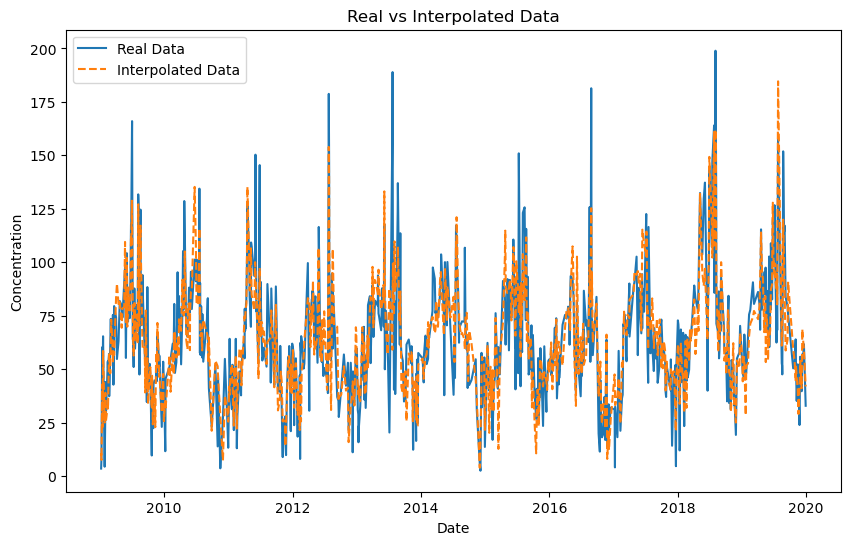

In [410]:
# Visualize the real and interpolated values
plt.figure(figsize=(10, 6))
plt.plot(merged_data['Concentration'], label='Real Data')
plt.plot(merged_data['Concentration_interpolated'], label='Interpolated Data', linestyle='dashed')
plt.title('Real vs Interpolated Data')
plt.xlabel('Date')
plt.ylabel('Concentration')
plt.legend()
plt.show()

# Polynomial Interpolation

In [411]:
# Step 1: Make a copy of the dataset
data_poly2_copy = data_poly2.copy()

In [412]:
# Step 2: Manually introduce NaN values

# Set a seed for reproducibility
np.random.seed(42)


data_poly2_copy.loc[data_poly2_copy.sample(frac=0.2).index, 'Concentration'] = np.nan

In [413]:
# Step 3: Interpolate the NaN values with a second-degree polynomial
data_poly2_copy['Concentration_interpolated'] = data_poly2_copy['Concentration'].interpolate(method='polynomial', order=2)

In [414]:
# Step 4: Take only the interpolated values and their corresponding date values
interpolated_data_poly2 = data_poly2_copy[pd.isna(data_poly2_copy['Concentration'])]

In [415]:
# List of columns to remove
columns_to_remove = ['Concentration']
# Use the drop method to remove the specified columns
interpolated_data_poly2 = interpolated_data_poly2.drop(columns=columns_to_remove)

In [416]:
data_poly2_copy = data_poly2_copy['Concentration_interpolated'].dropna()

In [417]:
# Step 5: Perform a right join on the interpolated dataset with the original dataset using the index
merged_data = pd.merge(data_poly2, interpolated_data_poly2, how='right', left_index=True, right_index=True)

In [418]:
# Step 6: Calculate the MSE
mse = mean_squared_error(merged_data['Concentration'], merged_data['Concentration_interpolated'])
print(f'Mean Squared Error (MSE): {mse:.2f}')

Mean Squared Error (MSE): 405.38


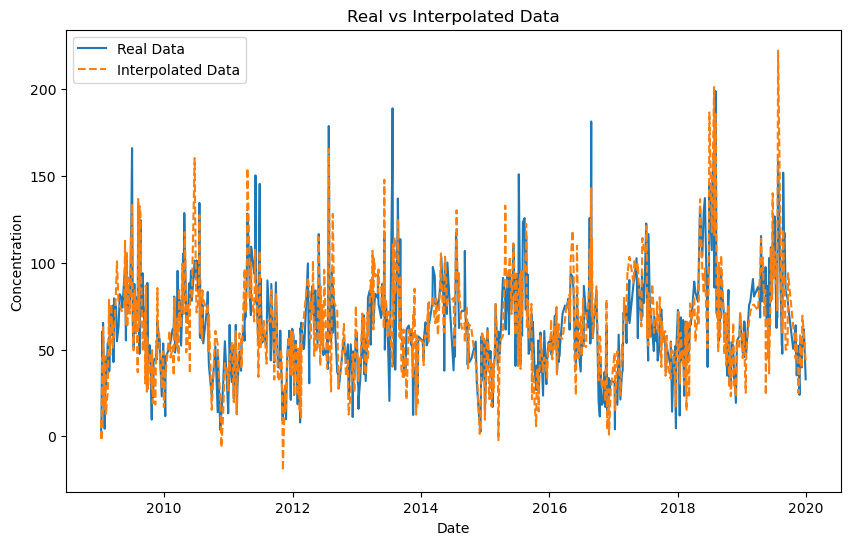

In [419]:
# Visualize the real and interpolated values
plt.figure(figsize=(10, 6))
plt.plot(merged_data['Concentration'], label='Real Data')
plt.plot(merged_data['Concentration_interpolated'], label='Interpolated Data', linestyle='dashed')
plt.title('Real vs Interpolated Data')
plt.xlabel('Date')
plt.ylabel('Concentration')
plt.legend()
plt.show()

# 3rd Degree Polynomial Interpolation 

Mean Squared Error (MSE): 431.08


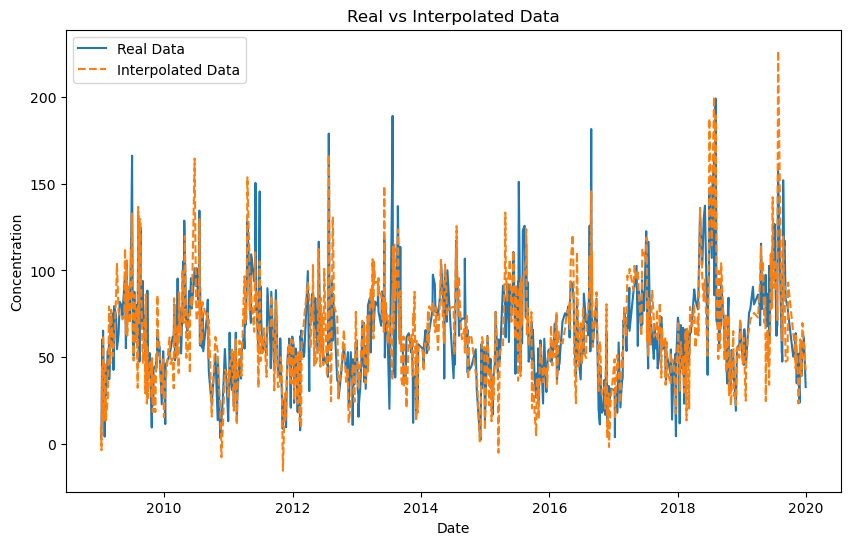

In [420]:
# Step 1: Make a copy of the dataset
data_poly3_copy = data_poly3.copy()

# Step 2: Manually introduce NaN values

# Set a seed for reproducibility
np.random.seed(42)

data_poly3_copy.loc[data_poly3_copy.sample(frac=0.2).index, 'Concentration'] = np.nan

# Step 3: Interpolate the NaN values with a third-degree polynomial
data_poly3_copy['Concentration_interpolated'] = data_poly3_copy['Concentration'].interpolate(method='polynomial', order=3)

# Step 4: Take only the interpolated values and their corresponding date values
interpolated_data_poly3 = data_poly3_copy[pd.isna(data_poly3_copy['Concentration'])]

# Step 5: Perform a right join on the interpolated dataset with the original dataset using the index
merged_data = pd.merge(data_poly3, interpolated_data_poly3[['Concentration_interpolated']], how='right', left_index=True, right_index=True)

# Step 6: Calculate the MSE
mse = mean_squared_error(merged_data['Concentration'], merged_data['Concentration_interpolated'])
print(f'Mean Squared Error (MSE): {mse:.2f}')

# Visualize the real and interpolated values
plt.figure(figsize=(10, 6))
plt.plot(merged_data['Concentration'], label='Real Data')
plt.plot(merged_data['Concentration_interpolated'], label='Interpolated Data', linestyle='dashed')
plt.title('Real vs Interpolated Data')
plt.xlabel('Date')
plt.ylabel('Concentration')
plt.legend()
plt.show()

# 4rd Degree Polynomial Interpolation 

Mean Squared Error (MSE) with 4th degree polynomial: 720.47


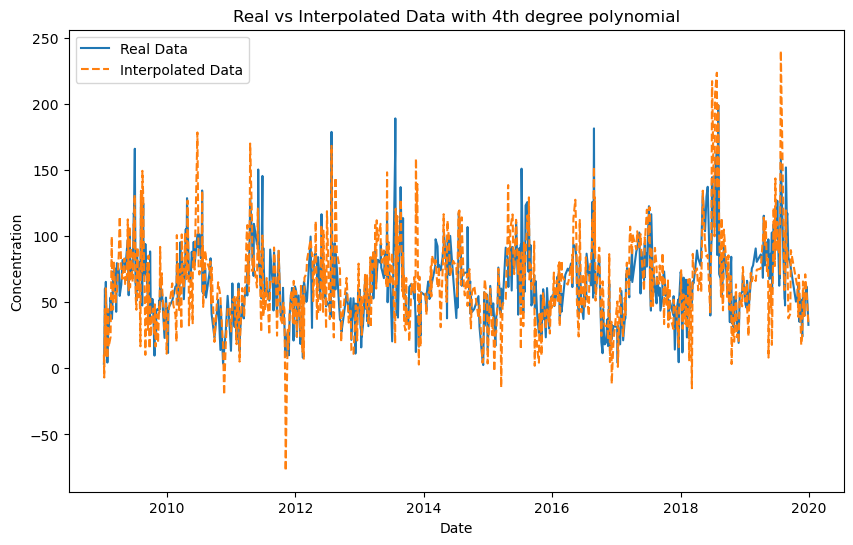

In [423]:
# Step 1: Make a copy of the dataset
data_poly5_copy = data_poly5.copy()

# Step 2: Manually introduce NaN values

# Set a seed for reproducibility
np.random.seed(42)

data_poly5_copy.loc[data_poly5_copy.sample(frac=0.2).index, 'Concentration'] = np.nan

# Step 3: Interpolate the NaN values with a fourth-degree polynomial
data_poly5_copy['Concentration_interpolated'] = data_poly5_copy['Concentration'].interpolate(method='polynomial', order=5)

# Step 4: Take only the interpolated values and their corresponding date values
interpolated_data_poly5 = data_poly5_copy[pd.isna(data_poly5_copy['Concentration'])]

# Step 5: Perform a right join on the interpolated dataset with the original dataset using the index
merged_data_poly5 = pd.merge(data_poly5, interpolated_data_poly5[['Concentration_interpolated']], how='right', left_index=True, right_index=True)

# Step 6: Calculate the MSE
mse_poly5 = mean_squared_error(merged_data_poly4['Concentration'], merged_data_poly5['Concentration_interpolated'])
print(f'Mean Squared Error (MSE) with 4th degree polynomial: {mse_poly4:.2f}')

# Visualize the real and interpolated values
plt.figure(figsize=(10, 6))
plt.plot(merged_data_poly4['Concentration'], label='Real Data')
plt.plot(merged_data_poly4['Concentration_interpolated'], label='Interpolated Data', linestyle='dashed')
plt.title('Real vs Interpolated Data with 4th degree polynomial')
plt.xlabel('Date')
plt.ylabel('Concentration')
plt.legend()
plt.show()

# Nearest Neighbor

In [401]:
# Step 1: Make a copy of the dataset
data_neighbor_copy = data_neighbor.copy()

# Step 2: Manually introduce NaN values

# Set a seed for reproducibility
np.random.seed(42)

data_neighbor_copy.loc[data_neighbor_copy.sample(frac=0.2).index, 'Concentration'] = np.nan

# Step 3: Interpolate the NaN values with nearest-neighbor interpolation
data_neighbor_copy['Concentration_interpolated'] = data_neighbor_copy['Concentration'].interpolate(method='nearest')

# Step 4: Take only the interpolated values and their corresponding date values
interpolated_data_nearest = data_neighbor_copy[pd.isna(data_neighbor_copy['Concentration'])]

# Step 5: Perform a right join on the interpolated dataset with the original dataset using the index
merged_data = pd.merge(data_neighbor, interpolated_data_nearest[['Concentration_interpolated']], how='right', left_index=True, right_index=True)

In [357]:
# Step 6: Calculate the MSE
mse = mean_squared_error(merged_data['Concentration'], merged_data['Concentration_interpolated'])
print(f'Mean Squared Error (MSE): {mse:.2f}')

Mean Squared Error (MSE): 390.03


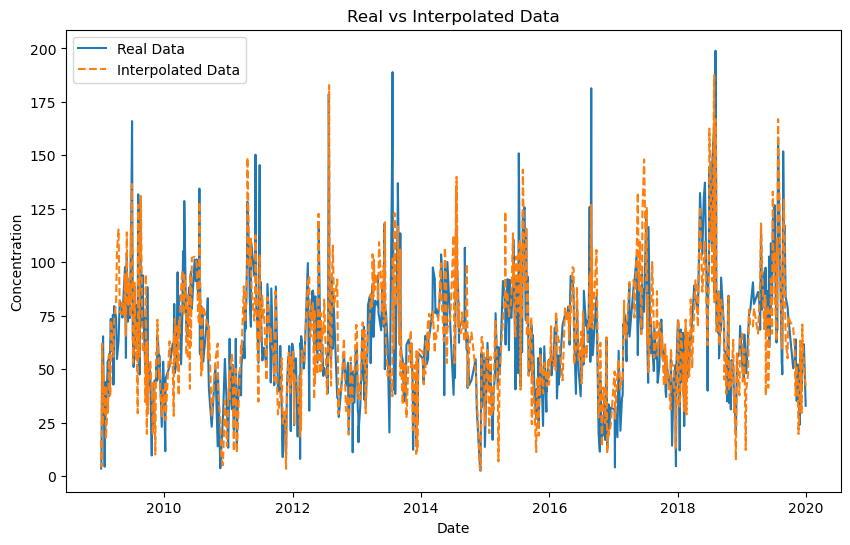

In [358]:
# Visualize the real and interpolated values
plt.figure(figsize=(10, 6))
plt.plot(merged_data['Concentration'], label='Real Data')
plt.plot(merged_data['Concentration_interpolated'], label='Interpolated Data', linestyle='dashed')
plt.title('Real vs Interpolated Data')
plt.xlabel('Date')
plt.ylabel('Concentration')
plt.legend()
plt.show()

# Time-based Interpolation

Mean Squared Error (MSE): 286.64


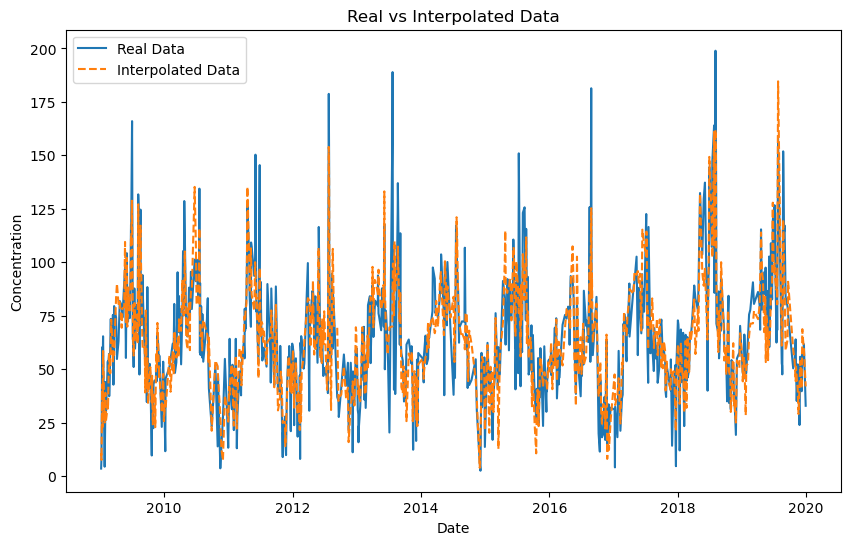

In [361]:
# Step 1: Make a copy of the dataset
data_time_copy = data_time.copy()

# Step 2: Manually introduce NaN values

# Set a seed for reproducibility
np.random.seed(42)

data_time_copy.loc[data_time_copy.sample(frac=0.2).index, 'Concentration'] = np.nan

# Step 3: Sort the dataframe by the 'Date' column for time-based interpolation
data_time_copy.sort_values('Date', inplace=True)

# Step 4: Interpolate the NaN values with time-based interpolation
data_time_copy['Concentration_interpolated'] = data_time_copy['Concentration'].interpolate(method='time')

# Step 5: Take only the interpolated values and their corresponding date values
interpolated_data_time = data_time_copy[pd.isna(data_time_copy['Concentration'])]

# Step 6: Perform a right join on the interpolated dataset with the original dataset using the index
merged_data = pd.merge(data_time, interpolated_data_time[['Concentration_interpolated']], how='right', left_index=True, right_index=True)

# Step 7: Calculate the MSE
mse = mean_squared_error(merged_data['Concentration'], merged_data['Concentration_interpolated'])
print(f'Mean Squared Error (MSE): {mse:.2f}')

# Visualize the real and interpolated values
plt.figure(figsize=(10, 6))
plt.plot(merged_data['Concentration'], label='Real Data')
plt.plot(merged_data['Concentration_interpolated'], label='Interpolated Data', linestyle='dashed')
plt.title('Real vs Interpolated Data')
plt.xlabel('Date')
plt.ylabel('Concentration')
plt.legend()
plt.show()

# Spline Interpolation

In [362]:
# Step 1: Make a copy of the dataset
data_spline_copy = data_spline.copy()

# Step 2: Manually introduce NaN values

# Set a seed for reproducibility
np.random.seed(42)

data_spline_copy.loc[data_spline_copy.sample(frac=0.2).index, 'Concentration'] = np.nan

# Step 3: Sort the dataframe by the 'Date' column for spline interpolation
data_spline_copy.sort_values('Date', inplace=True)

# Step 4: Interpolate the NaN values with spline interpolation
data_spline_copy['Concentration_interpolated'] = data_spline_copy['Concentration'].interpolate(method='spline', order=2)

# Step 5: Take only the interpolated values and their corresponding date values
interpolated_data_spline = data_spline_copy[pd.isna(data_spline_copy['Concentration'])]

# Step 6: Perform a right join on the interpolated dataset with the original dataset using the index
merged_data = pd.merge(data_spline, interpolated_data_spline[['Concentration_interpolated']], how='right', left_index=True, right_index=True)

Mean Squared Error (MSE): 393.85


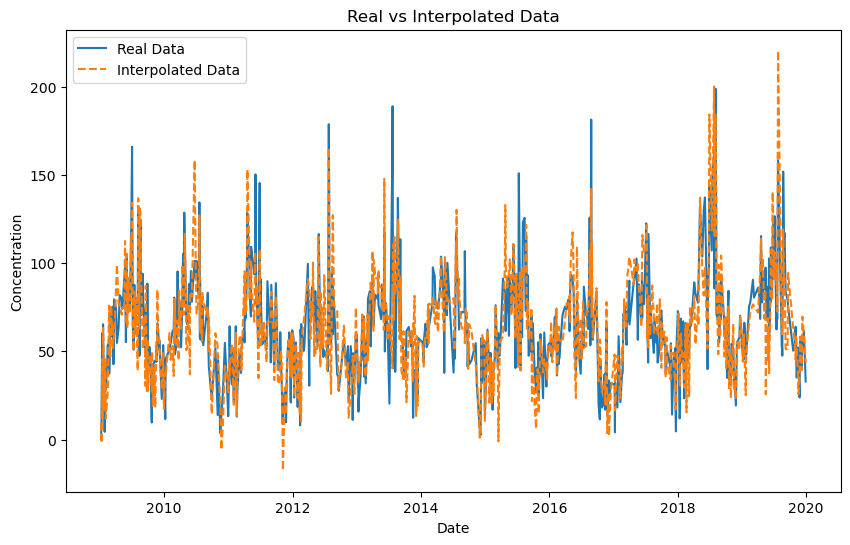

In [363]:
# Step 7: Calculate the MSE
mse = mean_squared_error(merged_data['Concentration'], merged_data['Concentration_interpolated'])
print(f'Mean Squared Error (MSE): {mse:.2f}')

# Visualize the real and interpolated values
plt.figure(figsize=(10, 6))
plt.plot(merged_data['Concentration'], label='Real Data')
plt.plot(merged_data['Concentration_interpolated'], label='Interpolated Data', linestyle='dashed')
plt.title('Real vs Interpolated Data')
plt.xlabel('Date')
plt.ylabel('Concentration')
plt.legend()
plt.show()

# Piecewise Polynomial

In [369]:
# Step 1: Make a copy of the dataset
data_piecewise_copy = data_piecewise.copy()

# Step 2: Manually introduce NaN values

# Set a seed for reproducibility
np.random.seed(42)

data_piecewise_copy.loc[data_piecewise_copy.sample(frac=0.2).index, 'Concentration'] = np.nan

# Step 3: Sort the dataframe by the 'Date' column for pchip interpolation
data_piecewise_copy.sort_values('Date', inplace=True)

# Step 4: Interpolate the NaN values with pchip interpolation
data_piecewise_copy['Concentration_interpolated'] = data_piecewise_copy['Concentration'].interpolate(method='pchip')

# Step 5: Take only the interpolated values and their corresponding date values
interpolated_data_piece = data_piecewise_copy[pd.isna(data_piecewise_copy['Concentration'])]

# Step 6: Perform a right join on the interpolated dataset with the original dataset using the index
merged_data = pd.merge(data_piecewise, interpolated_data_piece[['Concentration_interpolated']], how='right', left_index=True, right_index=True)

Mean Squared Error (MSE): 293.50


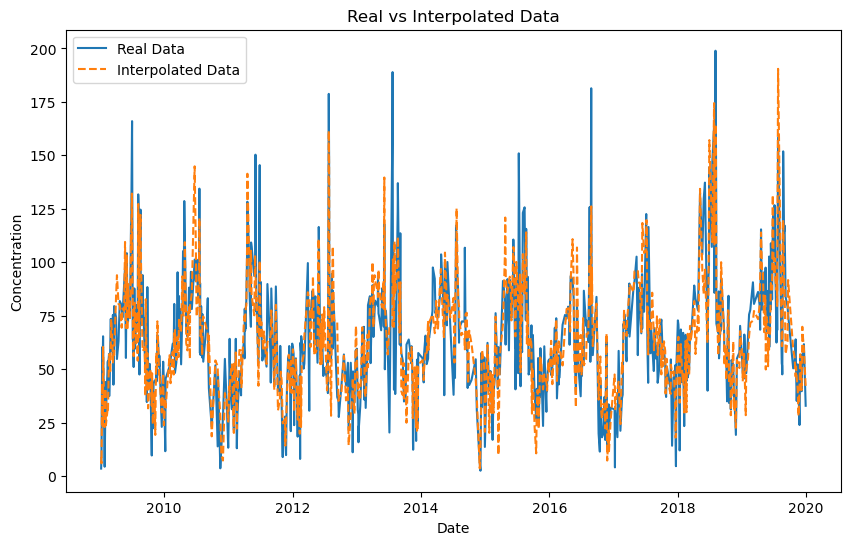

In [370]:
# Step 7: Calculate the MSE
mse = mean_squared_error(merged_data['Concentration'], merged_data['Concentration_interpolated'])
print(f'Mean Squared Error (MSE): {mse:.2f}')

# Visualize the real and interpolated values
plt.figure(figsize=(10, 6))
plt.plot(merged_data['Concentration'], label='Real Data')
plt.plot(merged_data['Concentration_interpolated'], label='Interpolated Data', linestyle='dashed')
plt.title('Real vs Interpolated Data')
plt.xlabel('Date')
plt.ylabel('Concentration')
plt.legend()
plt.show()

# Akima Interpolation

In [371]:
# Step 1: Make a copy of the dataset
data_akima_copy = data_akima.copy()

# Step 2: Manually introduce NaN values

# Set a seed for reproducibility
np.random.seed(42)

data_akima_copy.loc[data_akima_copy.sample(frac=0.2).index, 'Concentration'] = np.nan

# Step 3: Sort the dataframe by the index for Akima interpolation
data_akima_copy.sort_index(inplace=True)

# Step 4: Identify NaN values
nan_mask = pd.isna(data_akima_copy['Concentration'])

# Step 5: Create an Akima interpolator for non-NaN values
akima_interpolator = Akima1DInterpolator(data_akima_copy.index[~nan_mask], data_akima_copy['Concentration'].dropna())

# Step 6: Interpolate the NaN values using the Akima interpolator
data_akima_copy.loc[nan_mask, 'Concentration_interpolated'] = akima_interpolator(data_akima_copy.index[nan_mask])

# Step 7: Take only the interpolated values and their corresponding date values
interpolated_data_akima = data_akima_copy[nan_mask]

# Step 8: Perform a right join on the interpolated dataset with the original dataset using the index
merged_data = pd.merge(data_akima, interpolated_data_akima[['Concentration_interpolated']], how='right', left_index=True, right_index=True)

Mean Squared Error (MSE): 302.23


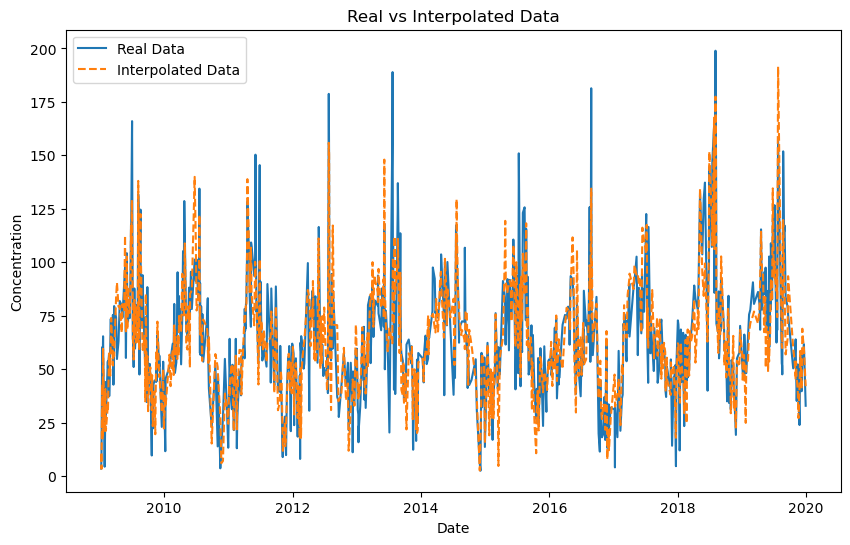

In [372]:
# Step 9: Calculate the MSE
mse = mean_squared_error(merged_data['Concentration'], merged_data['Concentration_interpolated'])
print(f'Mean Squared Error (MSE): {mse:.2f}')

# Visualize the real and interpolated values
plt.figure(figsize=(10, 6))
plt.plot(merged_data['Concentration'], label='Real Data')
plt.plot(merged_data['Concentration_interpolated'], label='Interpolated Data', linestyle='dashed')
plt.title('Real vs Interpolated Data')
plt.xlabel('Date')
plt.ylabel('Concentration')
plt.legend()
plt.show()

# Average

In [373]:
# Step 1: Make a copy of the dataset
data_average_copy = data_average.copy()

# Step 2: Manually introduce NaN values

# Set a seed for reproducibility
np.random.seed(42)

data_average_copy.loc[data_average_copy.sample(frac=0.2).index, 'Concentration'] = np.nan

# Step 3: Fill NaN values with the mean
mean_concentration = data_average_copy['Concentration'].mean()
data_average_copy['Concentration_interpolated'] = data_average_copy['Concentration'].fillna(mean_concentration)

# Step 4: Take only the interpolated values and their corresponding date values
interpolated_data_average = data_average_copy[pd.isna(data_average_copy['Concentration'])]

# Step 5: Perform a right join on the interpolated dataset with the original dataset using the index
merged_data = pd.merge(data_average, interpolated_data_average[['Concentration_interpolated']], how='right', left_index=True, right_index=True)

Mean Squared Error (MSE): 862.55


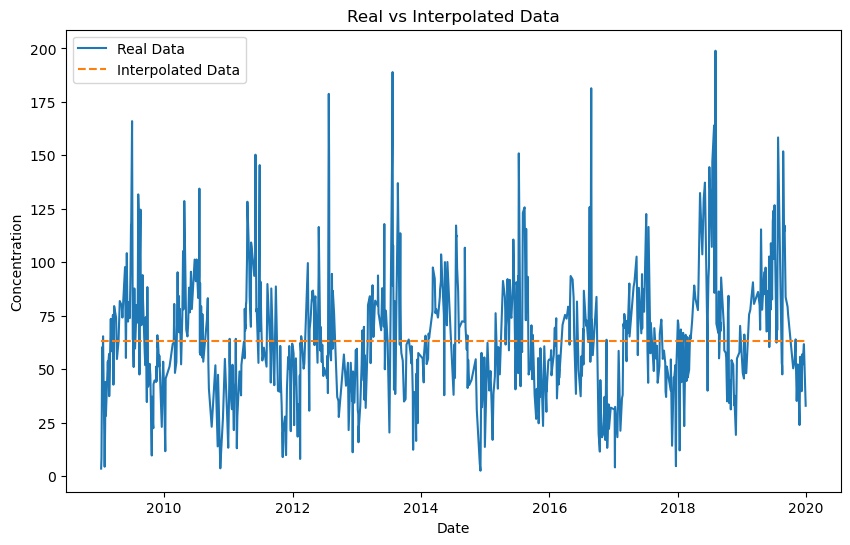

In [374]:
# Step 6: Calculate the MSE
mse = mean_squared_error(merged_data['Concentration'], merged_data['Concentration_interpolated'])
print(f'Mean Squared Error (MSE): {mse:.2f}')

# Visualize the real and interpolated values
plt.figure(figsize=(10, 6))
plt.plot(merged_data['Concentration'], label='Real Data')
plt.plot(merged_data['Concentration_interpolated'], label='Interpolated Data', linestyle='dashed')
plt.title('Real vs Interpolated Data')
plt.xlabel('Date')
plt.ylabel('Concentration')
plt.legend()
plt.show()

# Median

In [375]:
# Step 1: Make a copy of the dataset
data_median_copy = data_median.copy()

# Step 2: Manually introduce NaN values

# Set a seed for reproducibility
np.random.seed(42)

data_median_copy.loc[data_median_copy.sample(frac=0.2).index, 'Concentration'] = np.nan

# Step 3: Fill NaN values with the median
median_concentration = data_median_copy['Concentration'].median()
data_median_copy['Concentration_interpolated'] = data_median_copy['Concentration'].fillna(median_concentration)

# Step 4: Take only the interpolated values and their corresponding date values
interpolated_data_median = data_median_copy[pd.isna(data_median_copy['Concentration'])]

# Step 5: Perform a right join on the interpolated dataset with the original dataset using the index
merged_data = pd.merge(data_median, interpolated_data_median[['Concentration_interpolated']], how='right', left_index=True, right_index=True)

Mean Squared Error (MSE): 874.14


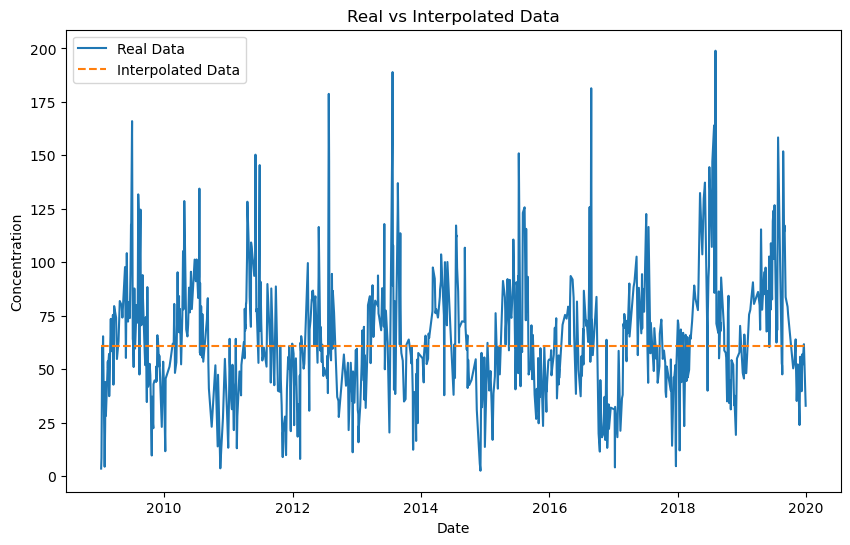

In [376]:
# Step 6: Calculate the MSE
mse = mean_squared_error(merged_data['Concentration'], merged_data['Concentration_interpolated'])
print(f'Mean Squared Error (MSE): {mse:.2f}')

# Visualize the real and interpolated values
plt.figure(figsize=(10, 6))
plt.plot(merged_data['Concentration'], label='Real Data')
plt.plot(merged_data['Concentration_interpolated'], label='Interpolated Data', linestyle='dashed')
plt.title('Real vs Interpolated Data')
plt.xlabel('Date')
plt.ylabel('Concentration')
plt.legend()
plt.show()